In [1]:
import pandas as pd
from fbprophet import Prophet
import datetime
import matplotlib.pyplot as plt
import warnings
from scipy import stats
import statsmodels.api as sm
%pylab inline
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'fbprophet'

In [191]:
heat = pd.read_csv("heat_energy.csv")

In [192]:
heat.date = heat.date.apply(lambda x:datetime.datetime.strptime(x, '%m/%d/%Y'))

Усреднение аномального значения

In [50]:
search_error = heat.loc[(heat['date'] == '2016-11-01') | (heat['date'] == '2017-11-01') | (heat['date'] == '2018-11-01') | (heat['date'] == '2019-11-01') | (heat['date'] == '2021-11-01')]
val = search_error['value_gc'].mean()
heat.loc[57, 'value_gc'] = val

In [193]:
heat.set_axis(['ds', 'y'], axis=1, inplace=True)

In [194]:
ds = heat.copy()

In [195]:
from fbprophet import Prophet
model = Prophet(yearly_seasonality=True) #Создавать Пророка только с ежегодной сезонностью, поскольку наши данные ежемесячны 
model.fit(ds) 
future = model.make_future_dataframe(periods=12, freq = 'MS')  
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
warnings.filterwarnings("ignore")

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [196]:
our_model = forecast.yhat[:-12]
ds['model'] = our_model
ds.index = ds.ds
del ds['ds']

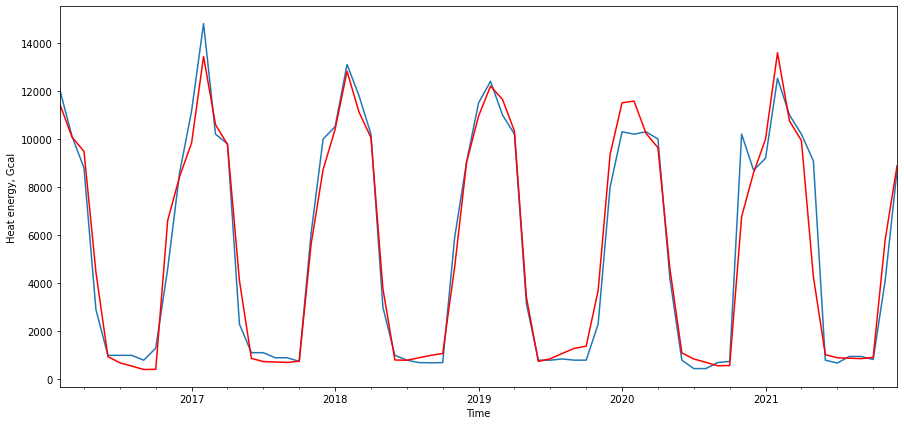

In [197]:
plt.figure(figsize(15,7))
ds.y.plot()
ds.model.plot(color='r')
plt.xlabel('Time')
plt.ylabel('Heat energy, Gcal')
pylab.show()

In [198]:
f = forecast.iloc[-12:]
f = f [['ds', 'yhat']]
f.index = f.ds
del f['ds']

Прогноз на декабрь 2021:

In [199]:
from datetime import datetime
ds2 = ds[['y']]
date_list = [datetime.strptime('2022-01-01', '%Y-%m-%d') + relativedelta(months = x) for x in range(0,1)]
future = pd.DataFrame (index=date_list, columns = ds2.columns)
ds2 = pd.concat([ds2, future])
ds2['forecast']= f

In [200]:
ds2

,y,forecast
2016-02-01,12000,NaN
2016-03-01,10110,NaN
2016-04-01,8800,NaN
2016-05-01,2900,NaN
2016-06-01,1000,NaN
...,...,...
2021-09-01,954,NaN
2021-10-01,827,NaN
2021-11-01,4090,NaN
2021-12-01,8700,NaN


In [201]:
from datetime import datetime
ds2 = ds[['y']]
date_list = [datetime.strptime('2022-01-01', '%Y-%m-%d') + relativedelta(months = x) for x in range(0,12)]
future = pd.DataFrame (index=date_list, columns = ds2.columns)
ds2 = pd.concat([ds2, future])
ds2['forecast']= f

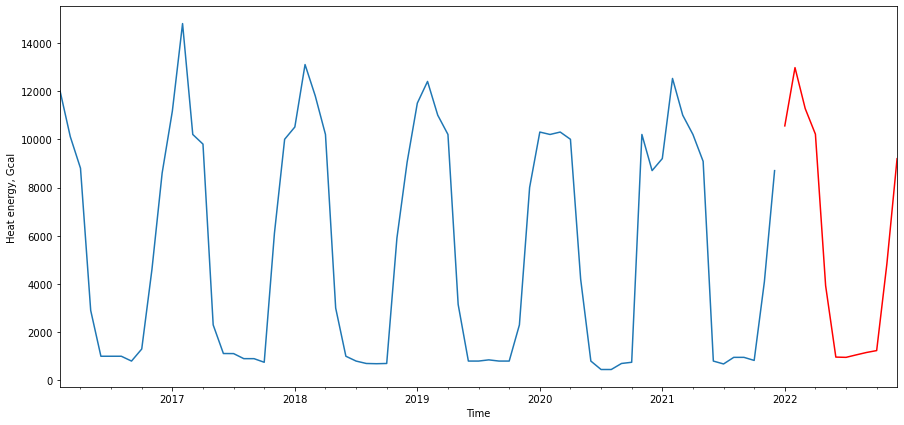

In [202]:
plt.figure(figsize(15,7))
ds2.y.plot()
ds2.forecast.plot(color='r')
plt.xlabel('Time')
plt.ylabel('Heat energy, Gcal')
pylab.show()

In [204]:
ds2[-12:]

,y,forecast
2022-01-01,NaN,10556.031607
2022-02-01,NaN,12972.619873
2022-03-01,NaN,11274.149388
2022-04-01,NaN,10212.267426
2022-05-01,NaN,3926.292065
2022-06-01,NaN,964.765688
2022-07-01,NaN,953.971289
2022-08-01,NaN,1056.875219
2022-09-01,NaN,1155.911240
2022-10-01,NaN,1235.027200


In [139]:
ds_quality = heat[:-12]

In [140]:
from fbprophet import Prophet
model = Prophet(yearly_seasonality=True) #Создавать Пророка только с ежегодной сезонностью, поскольку наши данные ежемесячны 
model.fit(ds_quality) 
future = model.make_future_dataframe(periods=12, freq = 'MS')  
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
warnings.filterwarnings("ignore")

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [143]:
real = heat[-12:]

In [145]:
real = real.loc[real['ds'] != '2021-05-01']
prognoz = prognoz.loc[prognoz['ds'] != '2021-05-01']

In [141]:
prognoz = forecast[['ds', 'yhat']][-12:]

In [142]:
prognoz

,ds,yhat
59,2021-01-01,10189.981331
60,2021-02-01,13978.605007
61,2021-03-01,10570.652640
62,2021-04-01,9760.528888
63,2021-05-01,3172.111067
64,2021-06-01,977.579397
65,2021-07-01,841.518099
66,2021-08-01,760.499295
67,2021-09-01,731.468832
68,2021-10-01,810.473123


In [146]:
real['e'] = real['y'] - prognoz['yhat']
real['p'] = 100 * real['e'] / real['y']
print ('MAPE', np.mean(abs(real['p']))) #cредняя абсолютная ошибка нашего прогноза в процентах mean absolute percentage error
print ('MAE', np.mean(abs(real['e'])))
warnings.filterwarnings("ignore")

MAPE 15.49325137442271
MAE 555.440053658746


### Спрогнозируем, используя преобразованный ряд (Бокса-Кокса)

In [217]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [221]:
ds_box = heat.copy()

Оптимальный параметр преобразования Бокса-Кокса: 0.117148
Критерий Дики-Фуллера: p=0.585335


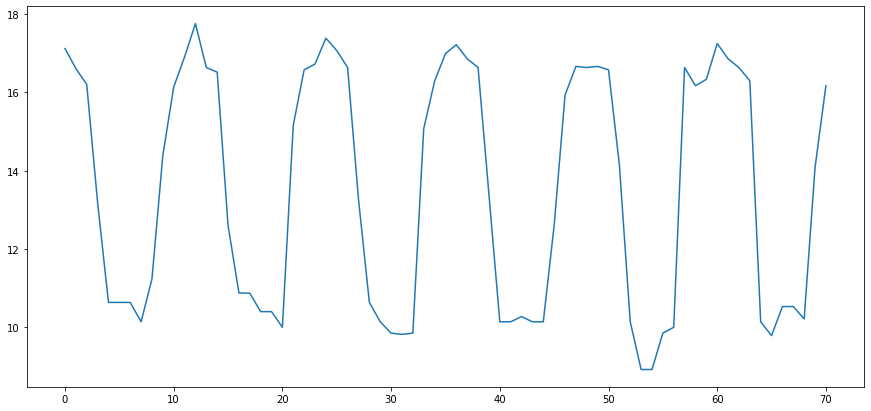

In [222]:
ds_box['y_box'], lmbda = stats.boxcox(ds_box.y)
plt.figure(figsize=(15,7))
ds_box.y_box.plot()
print ("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print ("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller (ds_box.y_box)[1])

In [223]:
del ds_box['y']

In [224]:
ds_box.set_axis(['ds', 'y'], axis=1, inplace=True)

In [225]:
ds_box

,ds,y
0,2016-02-01,17.116523
1,2016-03-01,16.606627
2,2016-04-01,16.201183
3,2016-05-01,13.184727
4,2016-06-01,10.637646
...,...,...
66,2021-08-01,10.532161
67,2021-09-01,10.532161
68,2021-10-01,10.215694
69,2021-11-01,14.077497


Прогнозируем на основе этого ряда.

In [227]:
from fbprophet import Prophet
model = Prophet(yearly_seasonality=True) #Создавать Пророка только с ежегодной сезонностью, поскольку наши данные ежемесячны 
model.fit(ds_box) 
future = model.make_future_dataframe(periods=1, freq = 'MS')  
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
warnings.filterwarnings("ignore")

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [228]:
prognoz = forecast[['ds','yhat']][-12:]

In [229]:
prognoz['model'] = invboxcox(prognoz.yhat, lmbda)

In [230]:
prognoz

,ds,yhat,model
60,2021-02-01,17.416342,13251.302647
61,2021-03-01,16.753829,10626.550107
62,2021-04-01,16.530131,9850.422702
63,2021-05-01,13.865412,3773.902413
64,2021-06-01,10.462786,924.775060
65,2021-07-01,10.092299,781.681593
66,2021-08-01,10.112282,788.868160
67,2021-09-01,10.174669,811.682293
68,2021-10-01,10.299006,858.894171
69,2021-11-01,14.808941,5367.049972


In [181]:
ds_box = ds_box[:-12]

In [182]:
from fbprophet import Prophet
model = Prophet(yearly_seasonality=True) #Создавать Пророка только с ежегодной сезонностью, поскольку наши данные ежемесячны 
model.fit(ds_box) 
future = model.make_future_dataframe(periods=12, freq = 'MS')  
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
warnings.filterwarnings("ignore")

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [183]:
real = heat[-12:]

In [184]:
prognoz = forecast[['ds','yhat']][-12:]

In [186]:
prognoz['model'] = invboxcox(prognoz.yhat, lmbda)

In [188]:
real = real.loc[real['ds'] != '2021-05-01']
prognoz = prognoz.loc[prognoz['ds'] != '2021-05-01']

In [189]:
real['e'] = real['y'] - prognoz['model']
real['p'] = 100 * real['e'] / real['y']
print ('MAPE', np.mean(abs(real['p']))) #cредняя абсолютная ошибка нашего прогноза в процентах mean absolute percentage error
print ('MAE', np.mean(abs(real['e'])))
warnings.filterwarnings("ignore")

MAPE 12.45998671238097
MAE 481.6576416319777


Преобразование Бокса-Кокса не повлияло на результат

In [173]:
prognoz

,ds,yhat,model
59,2021-01-01,16.215530,8843.661164
60,2021-02-01,17.249815,12542.793611
61,2021-03-01,16.481786,9689.425072
62,2021-04-01,16.250576,8951.120865
63,2021-05-01,13.098237,2802.894699
64,2021-06-01,10.251942,840.745677
65,2021-07-01,9.867179,704.622223
66,2021-08-01,9.727275,660.185517
67,2021-09-01,9.791160,680.159965
68,2021-10-01,9.995808,747.786222
